# Hierarchical Attention Network Using GRU architecture in RNN for movies reviews classification


### ***Charlotte Bredy-Maux & Kayané Robach***

#### Etude de cas n°3 - 3ème année de Magistère d'Economiste Statisticien

In [ ]:
!pip install tensorflow==1.14
!pip install keras==2.2.5

!wget -c "https://onedrive.live.com/download?cid=AE69638675180117&resid=AE69638675180117%2199289&authkey=AHgxt3xmgG0Fu5A" -O "data.zip"
!unzip data.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109.3 MB 53 kB/s 
     |████████████████████████████████| 488 kB 47.8 MB/s 
     |████████████████████████████████| 3.1 MB 18.2 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.2+zzzcolab20220719082949
    Uninstalling tensorflow-2.8.2+zzzcolab20220719082949:
      Successfully uninstalled tensorflow-2.8.2+zzzcolab20220719082949
ERROR: pip's dependency resolver does not currently ta

# Attention Layer

In [ ]:
def dot_product(x, kernel):
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

In [ ]:
import keras.backend as K
from keras.layers import Layer as Layer
from keras import initializers, regularizers, constraints

class AttentionWithContext(Layer):
    """
    Follows the work of Yang et al. [https://cs.stanford.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.

    To be put it on top of an RNN Layer (GRU) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    """
    
    def __init__(self, return_coefficients=False,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.return_coefficients = return_coefficients
        self.init = initializers.get('glorot_uniform')
        
        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)
        
        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)
        
        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)
    
    def build(self, input_shape):
        assert len(input_shape) == 3
        
        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        
        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)
        
        super(AttentionWithContext, self).build(input_shape)
    
    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None
    
    def call(self, x, mask=None):
        uit = dot_product(x, self.W)
        
        if self.bias:
            uit += self.b
        
        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)
        
        a = K.exp(ait)
        
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        
        a = K.expand_dims(a)

        # compute the attentional vector
        weighted_input = K.sum(a*x, axis = 1)
        
        if self.return_coefficients:
          ### [attentional vector, coefficients] ###
            return  [weighted_input, a]
        else:
          ### attentional vector only ###
            return  weighted_input
    
    def compute_output_shape(self, input_shape):
        if self.return_coefficients:
            return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[-1], 1)]
        else:
            return input_shape[0], input_shape[-1]

Using TensorFlow backend.
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Bidirectional GRU
#### add a RNN-GRU layer and a bidirectional wrapper ###
#### bidirectional: (https://keras.io/layers/wrappers/)
#### GRU: (https://keras.io/layers/recurrent/)

In [ ]:
from keras.layers import Bidirectional, GRU

def bidir_gru(my_seq,n_units):
    '''A convenient wrapper for bidirectional RNN with GRU units.'''
    return Bidirectional(layer = GRU(units=n_units, activation="tanh", return_sequences=True), merge_mode = "sum")(my_seq)

# Parameters

In [ ]:
import sys
import json
import operator
import numpy as np

path_root = ''
path_to_data = path_root + 'data/'

d = 30 # dimensionality of word embeddings
n_units = 50 # RNN layer dimensionality
drop_rate = 0.5 # dropout
mfw_idx = 2 # index of the most frequent words in the dictionary 
            # 0 is for the special padding token
            # 1 is for the special out-of-vocabulary token

padding_idx = 0
oov_idx = 1
batch_size = 32
nb_epochs = 6
my_optimizer = 'adam'
my_patience = 2 # for early stopping strategy

# Data Loading

In [ ]:
my_docs_array_train = np.load(path_to_data + 'docs_train.npy')
my_docs_array_test = np.load(path_to_data + 'docs_test.npy')

my_labels_array_train = np.load(path_to_data + 'labels_train.npy')
my_labels_array_test = np.load(path_to_data + 'labels_test.npy')

# load dictionary of word indexes (sorted by decreasing frequency across the corpus)
with open(path_to_data + 'word_to_index.json', 'r') as my_file:
    word_to_index = json.load(my_file)

# invert mapping
index_to_word = dict((v,k) for k,v in word_to_index.items())

In [ ]:
len(index_to_word)

29936

In [ ]:
my_docs_array_train.shape

(25000, 7, 30)

In [ ]:
my_labels_array_train.shape

(25000,)

In [ ]:
my_docs_array_test.shape

(25000, 7, 30)

In [ ]:
my_labels_array_test.shape

(25000,)

# Defining Architecture

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from keras.models import Model
from keras.layers import Input, Embedding, Dropout, TimeDistributed, Dense

sent_ints = Input(shape=(my_docs_array_train.shape[2],)) # vec of ints of variable size

sent_wv = Embedding(input_dim=len(index_to_word)+2, # vocab size
                    output_dim=d, # dimensionality of embedding space
                    input_length=my_docs_array_train.shape[2],
                    trainable=True
                    )(sent_ints)

sent_wv_dr = Dropout(drop_rate)(sent_wv)

# get the annotations for each word in the sent
sent_wa = bidir_gru(sent_wv_dr, n_units)

# get the attentional vector for the sentence
sent_att_vec, word_att_coeffs = AttentionWithContext(return_coefficients=True)(sent_wa)
sent_att_vec_dr = Dropout(drop_rate)(sent_att_vec)                      
sent_encoder = Model(sent_ints,sent_att_vec_dr) # return att vector not coef

doc_ints = Input(shape=(my_docs_array_train.shape[1],my_docs_array_train.shape[2],))
# apply the sentence encoder model to each sentence in the document. Search for 'TimeDistributed' in https://keras.io/layers/wrappers/
sent_att_vecs_dr = TimeDistributed(sent_encoder)(doc_ints)
doc_sa = bidir_gru(sent_att_vecs_dr,n_units) # get annotations for each sent in the doc
# get attentional vector for the doc
doc_att_vec, sent_att_coeffs = AttentionWithContext(return_coefficients=True)(doc_sa)
doc_att_vec_dr = Dropout(drop_rate)(doc_att_vec)
                  
preds = Dense(units=1,
              activation='sigmoid')(doc_att_vec_dr)

model = Model(doc_ints,preds)

model.compile(loss='binary_crossentropy',
              optimizer = my_optimizer,
              metrics = ['accuracy'])

print('model compiled')





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


model compiled


# Training

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

loading_pretrained = False

if not loading_pretrained:

    early_stopping = EarlyStopping(monitor='val_acc',
                                   patience= my_patience,
                                   mode='max')
    
    # save model corresponding to best epoch
    checkpointer = ModelCheckpoint(filepath=path_to_data + 'model', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True)
    
    # 200s/epoch on CPU - reaches 84.38% accuracy in 2 epochs

    # call the .fit() method on your model with the arguments: 
    # my_docs_array_train, my_labels_array_train, batch_size, nb_epochs, my_docs_array_test, my_labels_array_test, early_stopping
    # look at: https://keras.io/models/sequential/#fit

    history = model.fit(x = my_docs_array_train, 
              y = my_labels_array_train, 
              batch_size = batch_size, 
              epochs=nb_epochs, 
              validation_data = (my_docs_array_test, my_labels_array_test), 
              callbacks = [early_stopping, checkpointer]) # checkpointer
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show();

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show();

else:
    model.load_weights(path_to_data + 'model')

Train on 25000 samples, validate on 25000 samples
Epoch 1/6
25000/25000 [==============================] - 112s 4ms/step - loss: 0.2689 - acc: 0.8923 - val_loss: 0.3789 - val_acc: 0.8378

Epoch 00001: val_loss improved from inf to 0.37894, saving model to data/model
Epoch 2/6
25000/25000 [==============================] - 123s 5ms/step - loss: 0.1916 - acc: 0.9276 - val_loss: 0.4469 - val_acc: 0.8154

Epoch 00002: val_loss did not improve from 0.37894
Epoch 3/6
24992/25000 [============================>.] - ETA: 0s - loss: 0.1389 - acc: 0.9489

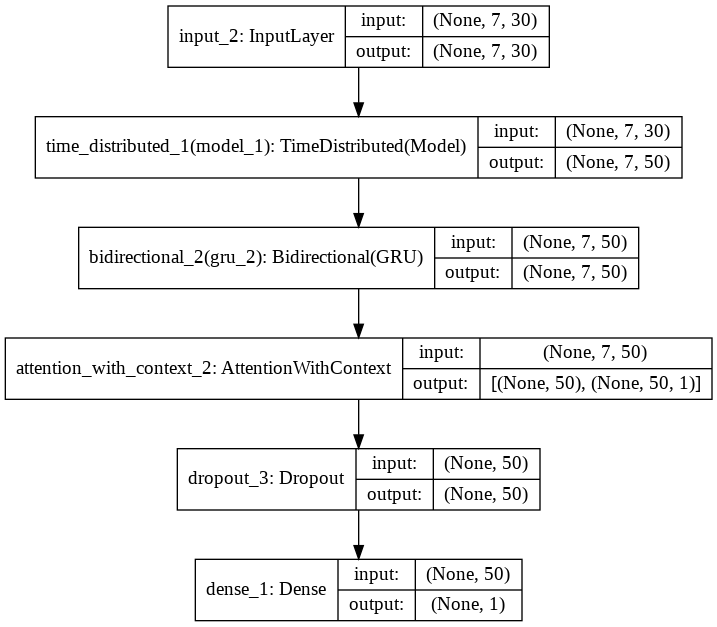

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
## Making predictions on our model
prediction = model.predict(my_docs_array_test)
y_pred = (prediction > 0.5)

from sklearn import metrics

metrics.f1_score(my_labels_array_test, y_pred)

0.8285192240407417

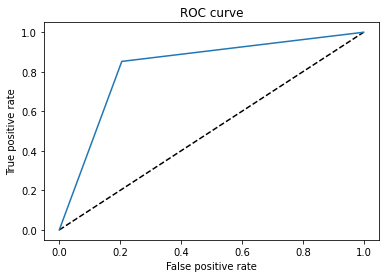

In [ ]:
## Plotting the results
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt
fpr_keras, tpr_keras, thresholds_keras = roc_curve(my_labels_array_test, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show();

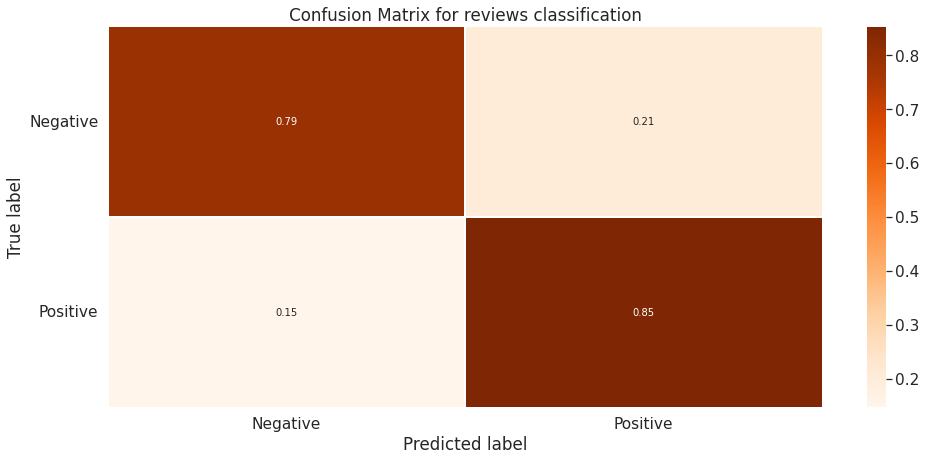

In [ ]:
import seaborn as sns
import matplotlib

# Get and reshape confusion matrix data
matrix=metrics.confusion_matrix(my_labels_array_test, y_pred, labels=[0, 1])
matrix=matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10}, cmap=matplotlib.cm.get_cmap('Oranges'), linewidths=0.2)

# Add labels to the plot
class_names = ['Negative', 'Positive']
tick_marks = np.arange(len(class_names)) + 0.5
plt.xticks(tick_marks, class_names, rotation=0)
plt.yticks(tick_marks, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title(f'Confusion Matrix for reviews classification')
plt.show()

# Extraction of Attention Coefficients

In [ ]:
my_review = my_docs_array_test[0:,:,:] # select last review

In [ ]:
index_to_word[1] = 'OOV'
my_review_text = [[index_to_word[idx] for idx in sent if idx in index_to_word] for sent in my_review.tolist()[0]]

In [ ]:
my_review_text

[['this',
  'movie',
  'gets',
  'a',
  '10',
  'because',
  'there',
  'is',
  'a',
  'lot',
  'of',
  'gore',
  'in',
  'OOV',
  'cares',
  'about',
  'the',
  'plot',
  'or',
  'the',
  'OOV',
  'is',
  'an',
  'Italian',
  'horror',
  'movie',
  'people',
  'so',
  'you',
  'know'],
 [],
 [],
 [],
 [],
 [],
 []]

In [ ]:
from keras.models import Model
# define intermediate models

get_word_att_coeffs = Model(sent_ints, word_att_coeffs)
# attention coeffs over the words in a sent

get_sent_attention_coeffs = Model(doc_ints, sent_att_coeffs)
# attention coeffs over the sents in the doc

my_review = my_docs_array_test[-1:,:,:] # select last review
# convert integer review to text
index_to_word[1] = 'OOV'
my_review_text = [[index_to_word[idx] for idx in sent if idx in index_to_word] for sent in my_review.tolist()[0]]

# Exemple of sentence encoding (preprocessing)

In [ ]:
my_docs_array_test[-1:,:,:][0][1]

array([1623,   63,   14,    6,  100,  869,    7,   97,   13,  856,   84,
         31,   92,    2,  236,    7,   15,   20,    3,   11,  283,   46,
          8, 7216,   82, 3013,    7,  184,    2,  128])

In [ ]:
print(my_review_text[1][:11])
print(my_review_text[1][11:22])
print(my_review_text[1][22:])

['Since', 'there', "'s", 'a', 'great', 'deal', 'of', 'people', 'that', 'apparently', 'did']
['not', 'get', 'the', 'point', 'of', 'this', 'movie', ',', 'I', "'d", 'like']
['to', 'contribute', 'my', 'interpretation', 'of', 'why', 'the', 'plot']


# Attention Over Sentences in the Document

In [ ]:
sent_coeffs = get_sent_attention_coeffs.predict(my_review)
sent_coeffs = sent_coeffs[0,:,:]

for elt in zip(sent_coeffs[:,0].tolist(),[' '.join(elt) for elt in my_review_text]):
    print(round(elt[0]*100,2),elt[1])

15.62 There 's a sign on The Lost Highway that says : OOV SPOILERS OOV ( but you already knew that , did n't you ? )
19.74 Since there 's a great deal of people that apparently did not get the point of this movie , I 'd like to contribute my interpretation of why the plot
17.47 As others have pointed out , one single viewing of this movie is not sufficient .
23.32 If you have the DVD of MD , you can OOV ' by looking at David Lynch 's 'Top 10 OOV to OOV MD ' ( but only upon second
10.97 ; ) First of all , Mulholland Drive is downright brilliant .
8.72 A masterpiece .
4.16 This is the kind of movie that refuse to leave your head .


# Attention Over Words in Each Sentence

In [ ]:
from keras.backend.tensorflow_backend import _to_tensor

my_review_tensor = _to_tensor(my_review,dtype='float32') # a layer, unlike a model, requires a TensorFlow tensor as input

# get the word attentional coefficients for each sentence in the document
word_coeffs = TimeDistributed(get_word_att_coeffs)(my_review_tensor) # apply the model on each sentence of my review

word_coeffs = K.eval(word_coeffs) # shape = (1, 7, 30, 1): (batch size, nb of sents in doc, nb of words per sent, coeff)
word_coeffs = word_coeffs[0,:,:,0] # shape = (7, 30) (coeff for each word in each sentence)
word_coeffs = sent_coeffs * word_coeffs # re-weight by sentence importance
word_coeffs = np.round((word_coeffs*100).astype(np.float64),2)

word_coeffs_list = word_coeffs.tolist()

# match text and coefficients
text_word_coeffs = [list(zip(words,word_coeffs_list[idx][:len(words)])) for idx,words in enumerate(my_review_text)]

for sent in text_word_coeffs:
    [print(elt) for elt in sent]  
    print('= = = =')

# sort words by importance within each sentence
text_word_coeffs_sorted = [sorted(elt,key=operator.itemgetter(1),reverse=True) for elt in text_word_coeffs]

for sent in text_word_coeffs_sorted:
    [print(elt) for elt in sent]
    print('= = = =')

# repeat with projection onto [0,1] TODO
text_word_coeffs_sorted = [sorted(elt,key=operator.itemgetter(1),reverse=True) for elt in text_word_coeffs]

for sent in text_word_coeffs_sorted:
    [print(elt) for elt in sent]
    print('= = = =')

('There', 0.06)
("'s", 0.07)
('a', 0.1)
('sign', 0.04)
('on', 0.08)
('The', 0.13)
('Lost', 2.11)
('Highway', 3.15)
('that', 1.31)
('says', 0.62)
(':', 0.26)
('OOV', 0.22)
('SPOILERS', 0.13)
('OOV', 0.13)
('(', 0.13)
('but', 0.2)
('you', 0.57)
('already', 0.31)
('knew', 0.65)
('that', 0.65)
(',', 0.85)
('did', 0.84)
("n't", 0.37)
('you', 0.74)
('?', 0.58)
(')', 0.74)
= = = =
('Since', 0.34)
('there', 0.38)
("'s", 0.32)
('a', 0.51)
('great', 5.4)
('deal', 3.82)
('of', 1.89)
('people', 1.22)
('that', 0.85)
('apparently', 0.8)
('did', 0.59)
('not', 0.16)
('get', 0.15)
('the', 0.13)
('point', 0.13)
('of', 0.16)
('this', 0.27)
('movie', 0.47)
(',', 0.44)
('I', 0.43)
("'d", 0.28)
('like', 0.17)
('to', 0.15)
('contribute', 0.12)
('my', 0.18)
('interpretation', 0.17)
('of', 0.08)
('why', 0.03)
('the', 0.04)
('plot', 0.04)
= = = =
('As', 1.45)
('others', 1.01)
('have', 0.62)
('pointed', 0.53)
('out', 0.29)
(',', 0.3)
('one', 0.46)
('single', 0.41)
('viewing', 1.43)
('of', 0.6)
('this', 1.04)
('m

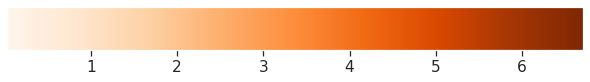

In [ ]:
import numpy as np
import pylab as pl

# source of the code : https://gist.github.com/ihsgnef/f13c35cd46624c8f458a4d23589ac768

def colorize(words, color_array):
    # words is a list of words
    # color_array is an array of numbers between 0 and 1 of length equal to words
    cmap = matplotlib.cm.get_cmap('Oranges')
    template = '<span class="barcode"; style="color: black; background-color: {}">{}</span>'
    colored_string = ''
    for word, color in zip(words, color_array):
        color = matplotlib.colors.rgb2hex(cmap(color)[:3])
        colored_string += template.format(color, '&nbsp' + word + '&nbsp')
    return colored_string
    
min_color = 1
max_color = 1
for sent in text_word_coeffs:

    words = [word for (word,coef) in sent]
    color_array = [coef for (word,coef) in sent]
    s = colorize(words, color_array)
    if min(color_array) < min_color:
        min_color = min(color_array)
    if max(color_array) > max_color:
        max_color = max(color_array)

    # to display :
    from IPython.display import display, HTML
    display(HTML(s))

a = np.array([[min_color,max_color]])
pl.figure(figsize=(5, 0.5))
img = pl.imshow(a, cmap='Oranges')
pl.gca().set_visible(False)
cax = pl.axes([0.2, 0.4, 1.6, 1.2])
pl.colorbar(orientation="horizontal", cax=cax);

In [ ]:
# select last review label
print(my_labels_array_test[-1])
print(y_pred[-1])

1
[ True]
